In [1]:
from data import Data
from object_dict import objdict
from report import Report
from expgrowth_study import study3
from SIR_study_2 import test_SIR_study

from expgrowth_study import fit_model, loglik_leastsquare, loglik_poisson, loglik_negbin

import math
import pandas as pd

import pwlf

##################
### RESTART THE KERNEL AFTER ANY CHANGE TO THE IMPORTS' CODE
##################

import numpy as np
from datetime import timedelta, date, datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import WeekdayLocator
from matplotlib.dates import MonthLocator
from matplotlib.dates import AutoDateLocator
from matplotlib.pyplot import cm
import matplotlib.colors as colors


In [2]:
#rpt = study3("Johns Hopkins", "US", "California", cutoff_positive=1,cutoff_death=1, truncate=0, window=2)
#test_SIR_study("Johns Hopkins", "US", "New York", cutoff_positive=1,cutoff_death=1, truncate=0, window=7, segments=6)


In [3]:
#--------------------------------------------------------------
def format_plot(ax, scale='linear', title=''):
    
    ax.grid(axis='y', which='major', alpha=0.5)
    ax.grid(axis='y', which='minor', linestyle=':', alpha=0.5)

    ax.grid(axis='x', which='major', alpha=0.5)
    #ax.legend()
    ax.set_title(title, pad=5)
    
    #ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '{:.1f}'.format(x)))       
    ax.set_yscale(scale)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,g}'.format(y)))
    if scale=='log':
        ax.set_ylim(bottom=1)

    ax.xaxis.set_major_locator(MonthLocator())
    #ax.xaxis.set_major_locator(WeekdayLocator())
    #ax.xaxis.set_minor_locator(WeekdayLocator())
    #ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))    
    ax.tick_params(axis='x', labelrotation=45)  #do not use autofmt_xdate() for subplots
    
    
    


In [4]:
#https://datascience.stackexchange.com/questions/8457/python-library-for-segmented-regression-a-k-a-piecewise-regression

from numpy.linalg import lstsq

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 50

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

In [5]:

def piecewiseexp(x, params, constants):
    
    r0 = params[0]
    ai = params[1]
    b0 = x[0]

    breakpoints = constants['breakpoints']
    
    res = r0 * np.exp(ai*(x-b0))

    if 'debug' in constants:
        print(0, ai, ai)
    
    for i, bi in enumerate(breakpoints):
        ai = params[i+2] - params[i+1]
        s = (x>=bi)
        res[s] *= np.exp(ai * (x[s]-bi))
        
        if 'debug' in constants:
            print(i+1, params[i+2], ai)
     
    return res

#transform auxiliary values (which are bounded [0,1] into the breakpoint dates)
def aux_to_breakpoints(aux, x0, xn, minwindow):
    breakpoints = []
    bi1 = x0
    for a in aux:
        bi = a * (xn-minwindow - (bi1+minwindow)) + bi1+minwindow
        breakpoints.append(bi)
        bi1=bi   
    return breakpoints

def piecewiseexp_diffevol_inner(aux, constants):
    
    x = constants['x']
    y = constants['y']
    bounds = constants['bounds']
    guess = constants['guess']
    alpha = constants['alpha']
    
    breakpoints = aux_to_breakpoints(aux, x[0], x[-1], constants['minwindow'])    

    params, likelihood, fit = fit_model(x, y, model_func=piecewiseexp, constants={'breakpoints':breakpoints}, 
                                        loglik_func=loglik_negbin, 
                                        guess=guess, bounds=bounds, alpha=alpha)

    return likelihood
 
    
from scipy.optimize import differential_evolution    
#https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html

def piecewiseexp_diffevol(x, y, breaks=1, minwindow=14):
    
    #prepare the bounds and guess vectors, and the other constants that will be used in the inner optimizer
    guess = [1, 1/7]   #initial count and initial growth rate
    bounds = [(1e-1,1e3),(-10/7, 10/7)]  #bounds for initial count and initial growth rate
    alpha = 1
    
    for i in range(breaks):
        guess.append(1/7)  #growth rate after breakpoint
        bounds.append((-10/7,10/7))
    
    constants = {'minwindow': minwindow, 'x':x, 'y':y, 'guess':guess, 'bounds':bounds, 'alpha':alpha}
    
    #bounds for the auxiliary variables that will be used to set the breakpoints
    #these auxiliary variables are optimized by differential_evolution()
    auxBounds = [(0,1)] * breaks  
    
    #find the optimal breakpoints
    res = differential_evolution(func=piecewiseexp_diffevol_inner, bounds=auxBounds, args=[constants])
    #print(res)
    
    #do the regression for the optimum breakpoints
    aux = res.x
    breakpoints = aux_to_breakpoints(aux, x[0], x[-1], minwindow) 
    
    params, likelihood, fit = fit_model(x, y, model_func=piecewiseexp, constants={'breakpoints':breakpoints}, 
                                        loglik_func=loglik_negbin, 
                                        guess=guess, bounds=bounds, alpha=alpha)


    return params, breakpoints, likelihood, fit
    
#--------------------------------------------------------------    
def piecewiseexp_gridsearch(x,y, breaks=1, minwindow=14):
    
    alpha = 0.1
    
    breakpoints = [(i+1)*minwindow for i in range(breaks)]
    
    guess = [1, 1/7]   #initial count and initial growth rate
    bounds = [(1e-1,1e3),(-10/7, 10/7)]  #bounds for initial count and initial growth rate
    
    for i in range(breaks):
        guess.append(1/7)  #growth rate after breakpoint
        bounds.append((-10/7,10/7))

    
    def reset_breakpoints(i):
        if i<=breaks-1:
            breakpoints[i] = breakpoints[i-1] + minwindow
            reset_breakpoints(i+1)   

        
    def next_breakpoint(i):
        breakpoints[i] = breakpoints[i] + 1
        reset_breakpoints(i+1)
        if i>=1 and breakpoints[-1] > x[-1] - minwindow:
            next_breakpoint(i-1)
    
    res = []
    
    isFirst = True
    min_params = None
    min_likelihood = None
    min_fit = None
    min_breakpoints = None
    
    while(True):
        
        params, likelihood, fit = fit_model(x, y, model_func=piecewiseexp, constants={'breakpoints':breakpoints}, 
                                            loglik_func=loglik_negbin, 
                                            guess=guess, bounds=bounds, alpha=alpha)
        
        
        res.append({'params':params, 'breakpoints':breakpoints, 'likelihood':likelihood, 'fit':fit})
                    
        if isFirst:
            isFirst = False
            min_params = params
            min_likelihood = likelihood
            min_fit = fit
            min_breakpoints = breakpoints.copy()
        else:
            if likelihood < min_likelihood:
                min_params = params
                min_likelihood = likelihood
                min_fit = fit
                min_breakpoints = breakpoints.copy()
                    
        next_breakpoint(breaks-1)
        
        if breakpoints[-1] > x[-1] - minwindow:
            break
    
    
    return min_params, min_likelihood, min_fit, min_breakpoints, res
    

    
    
def test_piecewiseexp():

    x = np.arange(100)

    guess = [1, 3/7, -1/7, 1.5/7]
    bounds = [(1e-2, 1e3), (-2,2), (-2,2), (-2,2)]
    breakpoints = [20,70]
    
    #create some data
    y =  piecewiseexp(x, guess, {'breakpoints':breakpoints})
    y = np.random.poisson(y)
    plt.plot(x,y, "x")
    plt.yscale('log')

    #regression knowing the breakpoints
    alpha = 0.1
    params, likelihood, fit = fit_model(x, y, model_func=piecewiseexp, constants={'breakpoints':breakpoints}, 
                                        loglik_func=loglik_negbin, 
                                        guess=guess, bounds=bounds, alpha=alpha)


    plt.plot(x,fit, "r:")
    
    
    #grid search regression to find the breakpoints
    #min_params, min_likelihood, min_fit, min_breakpoints, res = piecewiseexp_gridsearch(x,y,breaks=2,minwindow=14)
    #plt.plot(x, min_fit, "g-")

    
    #differential evolution search regression to find the breakpoints
    min_params, min_breakpoints, min_likelihood, min_fit = piecewiseexp_diffevol(x,y,breaks=2,minwindow=14)
    plt.plot(x, min_fit, "g-")  
    
    plt.show()


#test_piecewiseexp()





        from         to  doubling (days)
0 2020-02-23 2020-04-13                3
1 2020-04-13 2020-08-18              -17
2 2020-08-18 2020-10-29               54
3 2020-10-29 2020-11-07                6


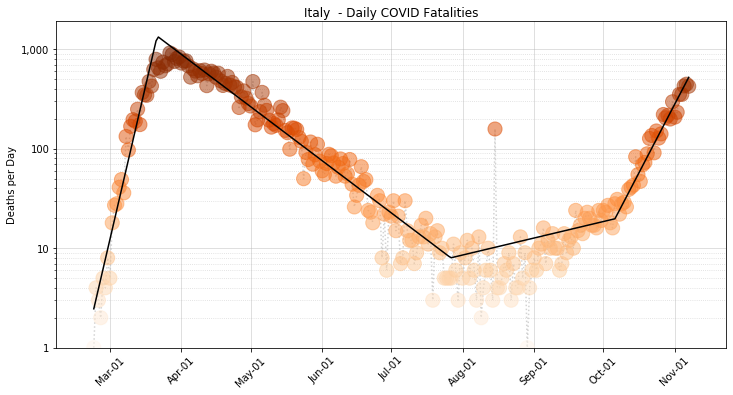

In [8]:
#-------------------------------
#Fit a piecewise exponential growth model to the daily fatalities data
#-------------------------------
def piecewiseexp_study(d, output, breaks=3, minwindow=14):

    fig, axs = plt.subplots(1,1,figsize=(12,6))  

    #calculate the regression with SegmentedLinearReg
    #------------------------------------------------
    #X = d.x[d.minD+1:]
    #Y = np.log(d.dfatalities)
    #Y = np.nan_to_num(Y)
    #x,y = SegmentedLinearReg(X, Y, [50,100,150])
    #xd = [d.minDate + timedelta(days=int(dd)) for dd in x]
    #xd = [np.datetime64(d.minDate + timedelta(days=int(dd))) for dd in x]
    #yexp = np.exp(y)
    #axs.plot(xd, yexp, 'k:', zorder=3)

    #calculate the regression with a grid search
    #-------------------------------------------
    #min_params, min_likelihood, min_fit, min_breakpoints, res = piecewiseexp_gridsearch(d.x[d.minD+1:],d.dfatalities,
    #                                                                                    breaks=breaks,minwindow=minwindow)
    #axs.plot(d.xd[d.minD+1:], min_fit, "r-", zorder=4)


    #calculate the regression with PWLF
    #https://github.com/cjekel/piecewise_linear_fit_py/blob/master/examples/fitForSpecifiedNumberOfLineSegments.py
    #------------------------------------------------

    #my_pwlf = pwlf.PiecewiseLinFit(X,Y)
    #res = my_pwlf.fit(breaks) #number of line segments
    #y = my_pwlf.predict(X)
    #yexp = np.exp(y)
    #axs.plot(d.xd[d.minD+1:], yexp, 'r:', zorder=3)

    #calculate the regression with Differential evolution
    #----------------------------------------------------
    min_params, min_breakpoints, min_likelihood, min_fit = piecewiseexp_diffevol(d.x[d.minD+1:],d.dfatalities,
                                                                                        breaks=breaks,minwindow=minwindow)
    axs.plot(d.xd[d.minD+1:], min_fit, "k-", zorder=4)


    #plot the data
    axs.scatter(d.xd[d.minD+1:], d.dfatalities, 
                marker='o', s=200, alpha=0.5, 
                c = d.dfatalities, cmap = 'Oranges', norm=colors.LogNorm(vmin=1, vmax=1000), zorder=2,
                label='fatalities')

    axs.plot(d.xd[d.minD+1:], d.dfatalities, ':', c='lightgrey', zorder=1)

    format_plot(axs, 'log', '{} {} - Daily COVID Fatalities'.format(d.region, d.state))
    axs.set_ylabel("Deaths per Day")

    #calculate the doubling time for each segment
    #--------------------------------------------
    res = []  

    d0 = np.datetime64(d.xd.iloc[d.minD+1])
    for i,b in enumerate(min_breakpoints):
        d1 = np.datetime64(d.xd.iloc[d.minD+1] + timedelta(int(b)))
        res.append({'from':d0, 'to':d1, 'doubling (days)': int(np.log(2)/min_params[i+1])})
        d0 = d1

    d1 = np.datetime64(d.xd.iloc[-1])
    res.append({'from':d0, 'to':d1, 'doubling (days)': int(np.log(2)/min_params[-1])})

    res = pd.DataFrame(res)
    print(res)

    #------------
    output.record('PieceWise Exponential Growth model', fig, 'MPLPNG')    
    output.record('Doubling Time', res.to_html(), 'HTML')
    
    return output

#----------------------------
source = 'Johns Hopkins'    
region = 'Italy'
state = ''

output = Report()

cutoff_positive = 1
cutoff_death = 1
truncate = 0
d = Data(source=source, region=region, state=state, county="", cutoff_positive=cutoff_positive, cutoff_death=cutoff_death, truncate=truncate) 

output = piecewiseexp_study(d, output, breaks=3, minwindow=14)



In [9]:
output

Report([('PieceWise_Exponential_Growth_model',
         {'name': 'PieceWise_Exponential_Growth_model',
          'datatype': 'MPLPNG',
          'data': <Figure size 864x432 with 1 Axes>}),
        ('Doubling_Time',
         {'name': 'Doubling_Time',
          'datatype': 'HTML',
          'data': '<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>from</th>\n      <th>to</th>\n      <th>doubling (days)</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>2020-02-23</td>\n      <td>2020-04-13</td>\n      <td>3</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>2020-04-13</td>\n      <td>2020-08-18</td>\n      <td>-17</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>2020-08-18</td>\n      <td>2020-10-29</td>\n      <td>54</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>2020-10-29</td>\n      <td>2020-11-07</td>\n      <td>6</td>\n    </tr>\n  </tbody>\n</table>'})])